In [1]:
!date

Tue Oct 15 10:35:57 EDT 2024


In [2]:
pwd

'/mmfs1/data/aglinska/BC-ABCD-denoise/Code'

In [87]:
import os
import pandas as pd
import numpy as np
import ants
from matplotlib import pyplot as plt
from tqdm import tqdm

In [892]:
#epi_fn = '../Data/020-fmriprepped/{sub}/ses-baselineYear1Arm1/func/{sub}_ses-baselineYear1Arm1_task-nback_run-0{r}_space-MNI152NLin2009cAsym_res-2_desc-COMPCORR_bold.nii'
epi_fn = '../Data/020-fmriprepped/{sub}/ses-baselineYear1Arm1/func/{sub}_ses-baselineYear1Arm1_task-nback_run-0{r}_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii'
mot_fn = '../Data/010-Data_bids2/{sub}/ses-baselineYear1Arm1/func/{sub}_ses-baselineYear1Arm1_task-nback_run-0{r}_events.tsv'

In [893]:
ffa = ants.image_read('../Misc/ffa_mask_resampled.nii')
print(ffa.numpy().sum())

682.0


In [894]:
subs = [i for i in os.listdir('../Data/020-fmriprepped/') if all((i.startswith('sub-'),not i.endswith('.html')))]
subs = [sub for sub in subs if all((os.path.exists(epi_fn.format(sub=sub,r=1)),
os.path.exists(epi_fn.format(sub=sub,r=2)),
os.path.exists(mot_fn.format(sub=sub,r=1)),
os.path.exists(mot_fn.format(sub=sub,r=2))))]
len(subs)

30

In [895]:
def norm(vec):
    return (vec-vec.min()) / (vec.max()-vec.min())

In [896]:
from nilearn.glm.first_level import make_first_level_design_matrix
ffa_arrs = []
X1s = []
X1s_sorted = []

for s in tqdm(range(len(subs))):
   for r in [1,2]:
        # s = 0
        # r = 1
        sub = subs[s]
        
        mot = pd.read_csv(mot_fn.format(sub=sub,r=r),delimiter='\t')
        
        t_r = 0.8  # repetition time is 1 second
        n_scans = 370  # the acquisition comprises 128 scans
        frame_times = (np.arange(n_scans) * t_r)
        
        X1 = make_first_level_design_matrix(frame_times,mot,drift_model="polynomial",drift_order=3,hrf_model="SPM") #
        
        endplate = pd.DataFrame([mot.iloc[-1]['onset']+mot.iloc[-1]['duration']],columns=['onset'])+10
        endplate['duration'] = 10.0
        endplate['trial_type'] = 'endplate'
        mot = pd.concat([mot,endplate])
        
        mot.iloc[np.nonzero(mot['trial_type'].values=='cue')[0]]=mot.iloc[np.nonzero(mot['trial_type'].values=='cue')[0]+1]
        mot['onset_TR'] = mot['onset'].values/t_r
        mot['end_TR'] = (mot['onset'].values+mot['duration'].values) / t_r
        mot['tr_mid'] = (mot['end_TR'].values+mot['onset_TR'].values)/2
        
        X1['trial_type'] = [mot.iloc[np.argmin(abs(tr-mot['tr_mid'].values))]['trial_type'] for tr in range(len(X1))]
        X1['idx'] = np.arange(len(X1))
        
        X1_sorted = X1.sort_values(['trial_type','idx'])
        im = ants.image_read(epi_fn.format(sub=sub,r=r))
        #print(im.shape)
        im_arr = im.numpy()
        im_arr[:,:,:,0:8] = im_arr[:,:,:,8::].mean(axis=-1)[:,:,:,np.newaxis]
        
        if im.shape[-1]<370:
            d = 370-im_arr.shape[-1]
            pad = np.concatenate([im_arr.mean(axis=-1)[:,:,:,np.newaxis] for _ in range(d)],axis=-1)
            im_arr = np.concatenate((im_arr,pad),axis=-1)
        if im.shape[-1]>370:
            im_arr = im_arr[:,:,:,0:370]
            
        vec = im_arr[ffa.numpy()==1].mean(axis=0)[X1_sorted['idx'].values]
        vec = norm(vec)
        ffa_arrs.append(vec)
        X1s.append(X1)
        X1s_sorted.append(X1_sorted)

100%|███████████████████████████████████████████| 30/30 [04:31<00:00,  9.06s/it]


In [897]:
im_arr.shape

(97, 115, 97, 370)

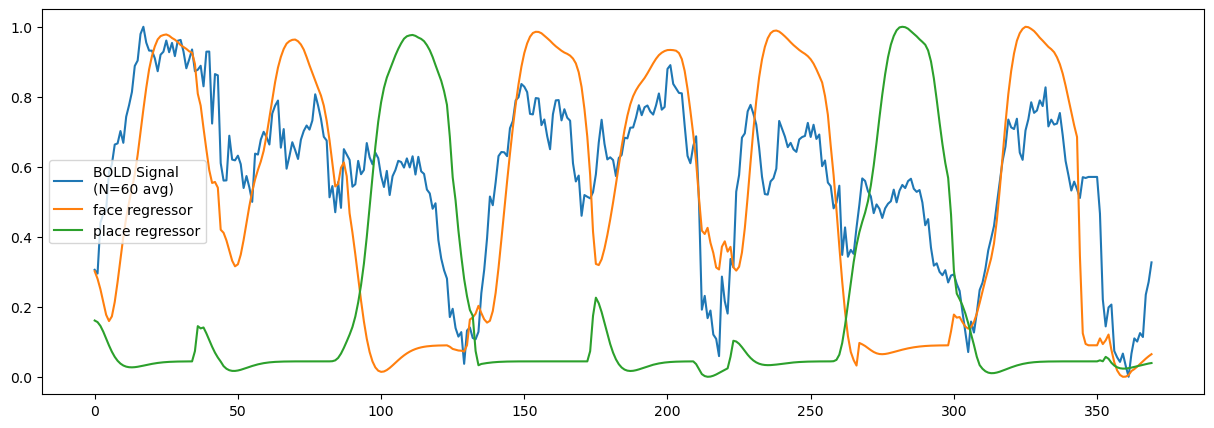

In [898]:
arr = np.array(ffa_arrs).mean(0)

plt.figure(figsize=(15,5))
plt.plot(norm(arr))

face_reg = np.array([val[['0_back_negface','0_back_neutface','0_back_posface','2_back_negface','2_back_neutface','2_back_posface']].values.mean(axis=1) for val in X1s_sorted]).mean(axis=0)
plt.plot(norm(face_reg))

place_reg = np.array([val[['0_back_place','2_back_place']].values.mean(axis=1) for val in X1s_sorted]).mean(axis=0)
plt.plot(norm(place_reg))

plt.legend(['BOLD Signal\n(N={} avg)'.format(len(ffa_arrs)),'face regressor','place regressor'])

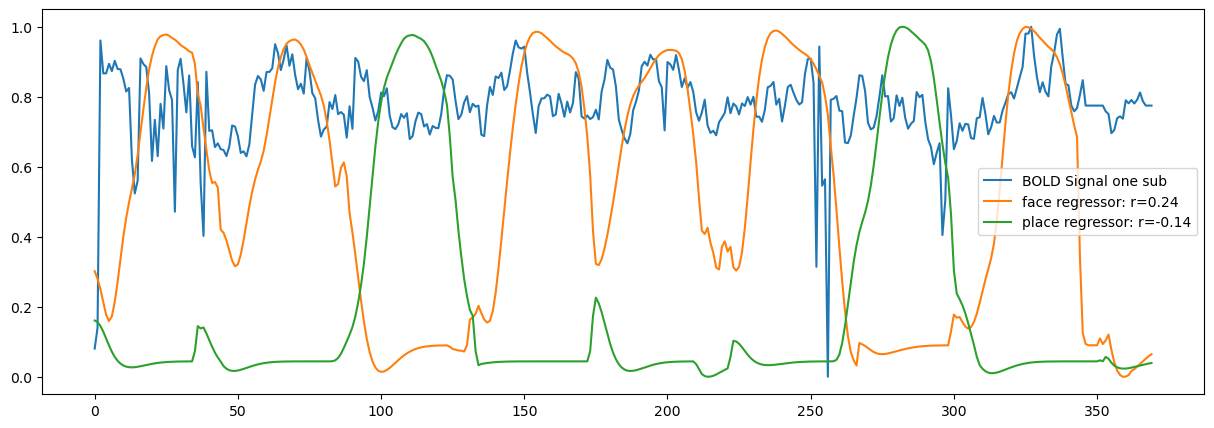

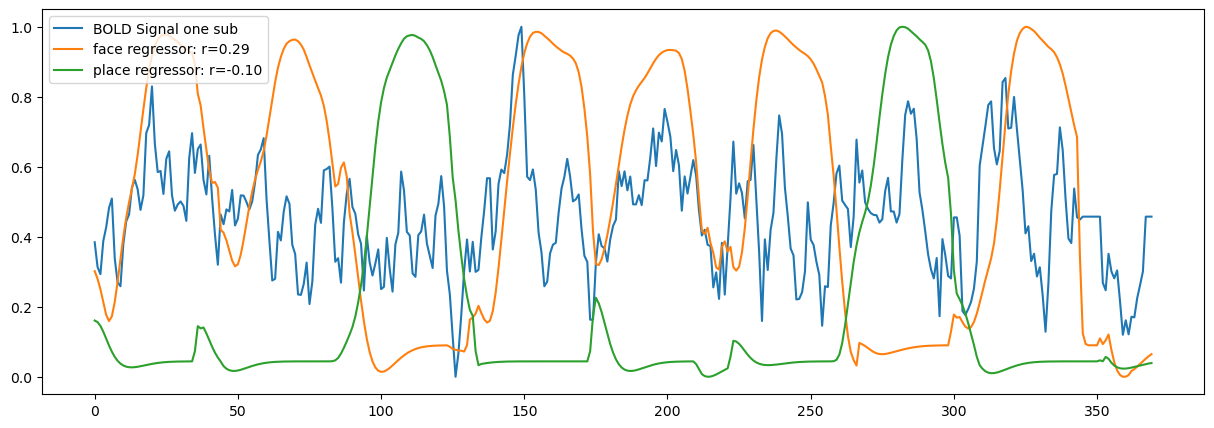

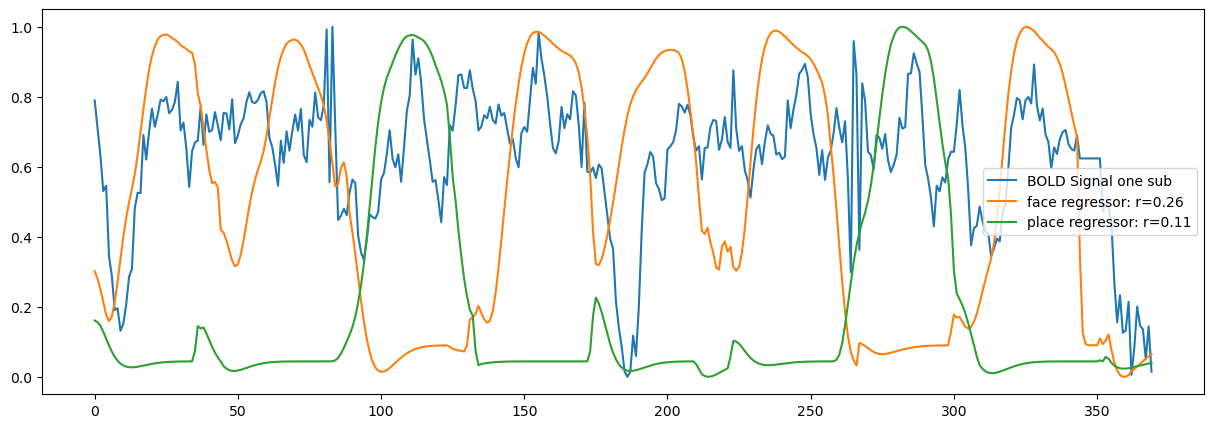

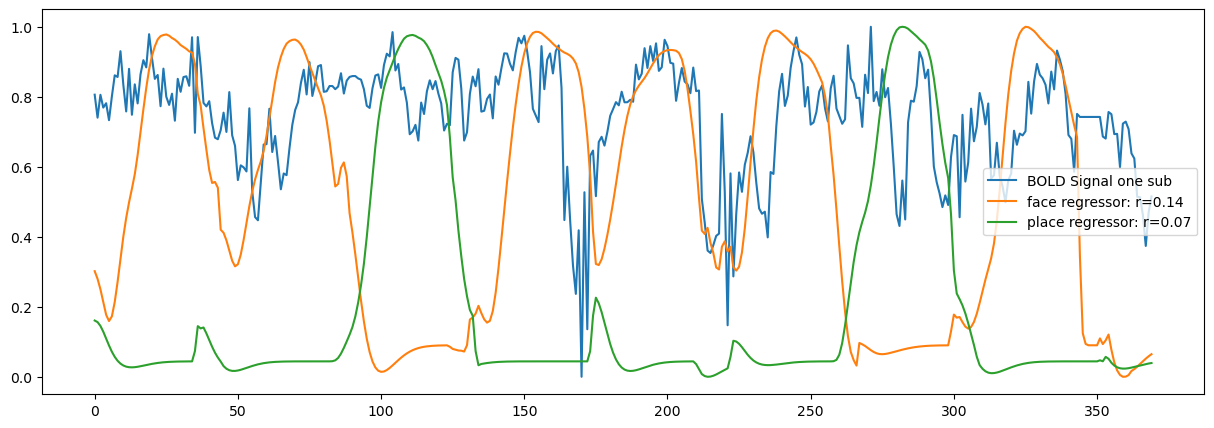

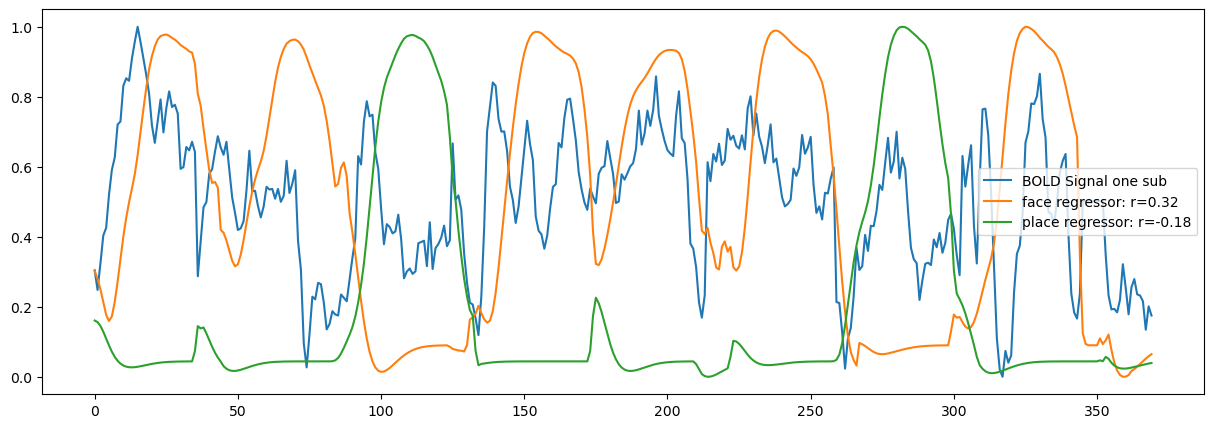

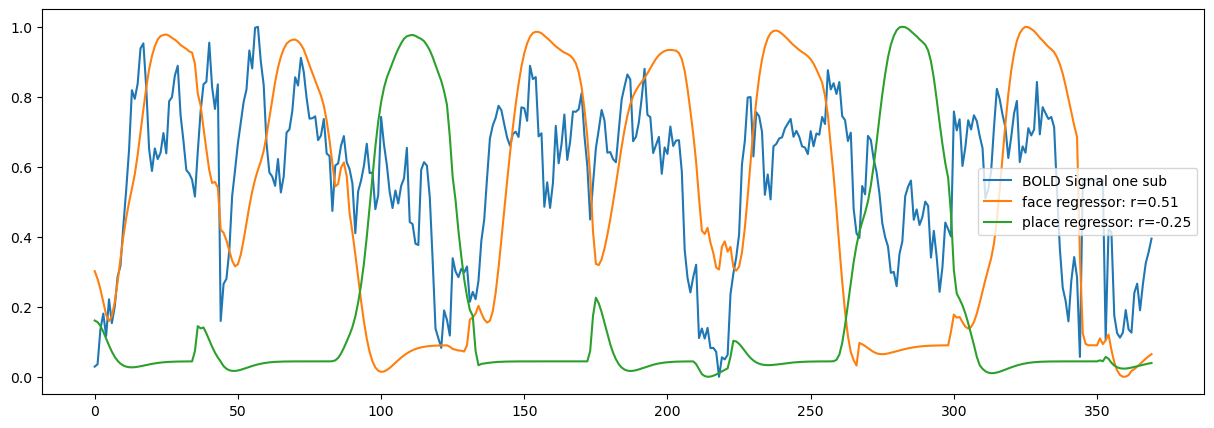

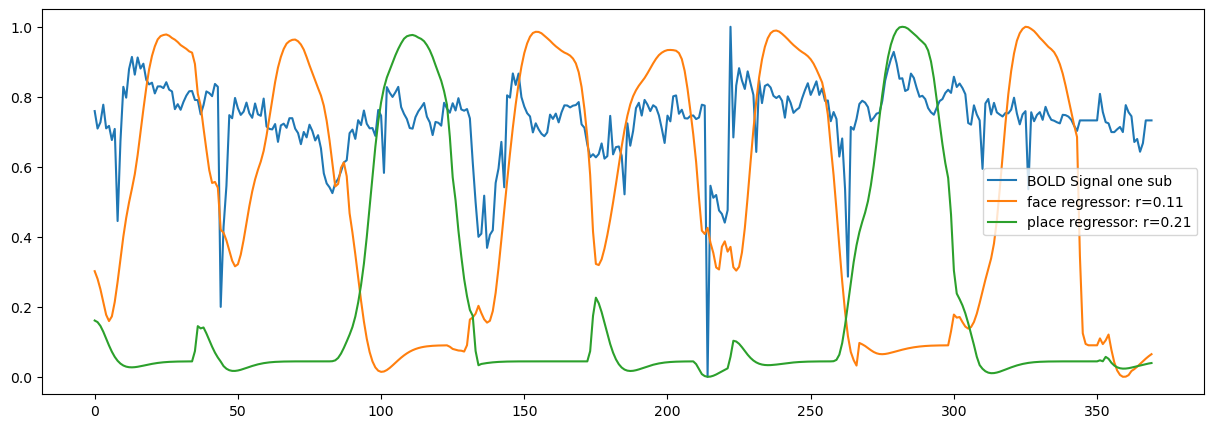

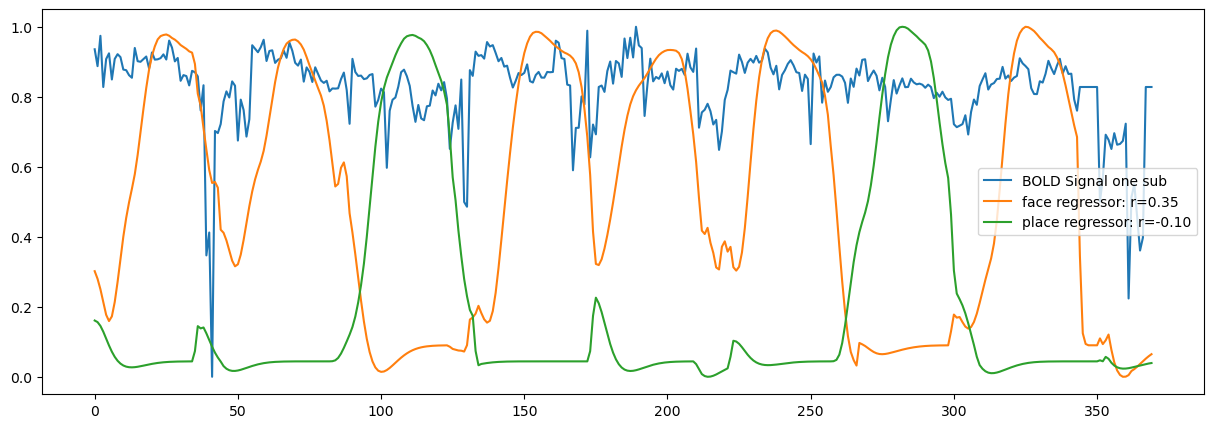

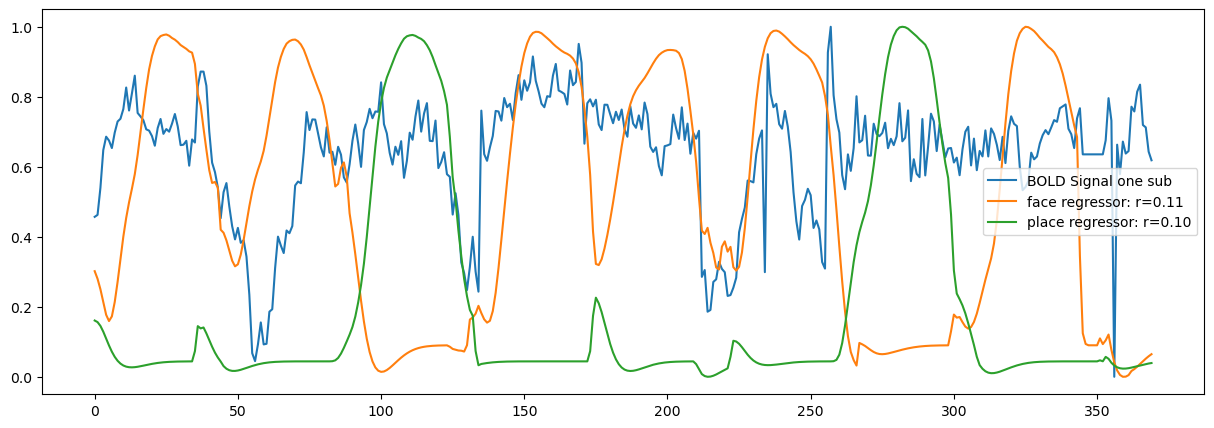

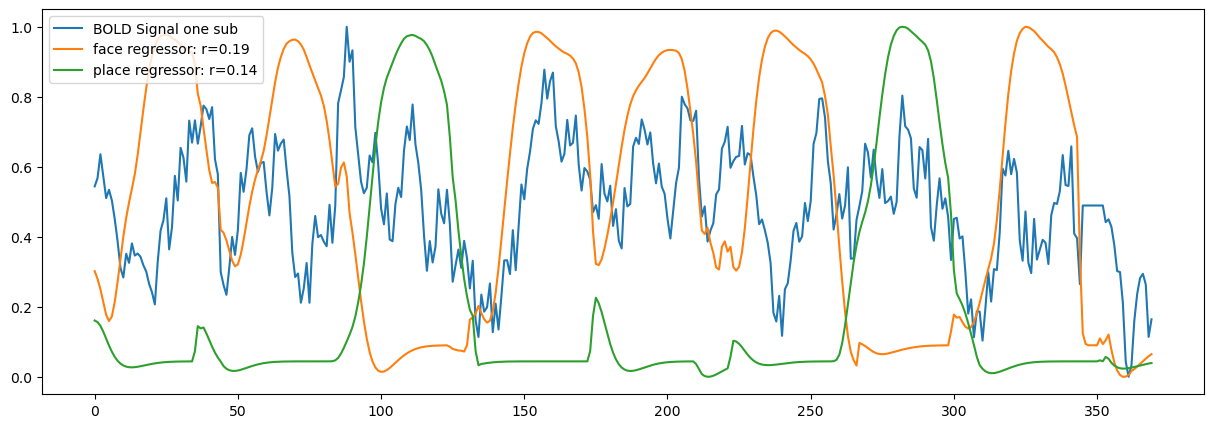

In [921]:
for s in range(10):
    arr = np.array(ffa_arrs)[s,:]
    #arr = np.array(ffa_arrs).mean(0)
    
    plt.figure(figsize=(15,5))
    plt.plot(norm(arr))
    
    face_reg = np.array([val[['0_back_negface','0_back_neutface','0_back_posface','2_back_negface','2_back_neutface','2_back_posface']].values.mean(axis=1) for val in X1s_sorted]).mean(axis=0)
    plt.plot(norm(face_reg))
    
    place_reg = np.array([val[['0_back_place','2_back_place']].values.mean(axis=1) for val in X1s_sorted]).mean(axis=0)
    plt.plot(norm(place_reg))
    
    plt.legend(['BOLD Signal one sub'.format(len(ffa_arrs)),'face regressor: r={:.2f}'.format(np.corrcoef(arr,face_reg)[0,1]),'place regressor: r={:.2f}'.format(np.corrcoef(arr,place_reg)[0,1])])

In [900]:
# FFX
print(np.corrcoef(arr,face_reg)[0,1])
print(np.corrcoef(arr,place_reg)[0,1])

0.19456418031348896
0.13636348997925662


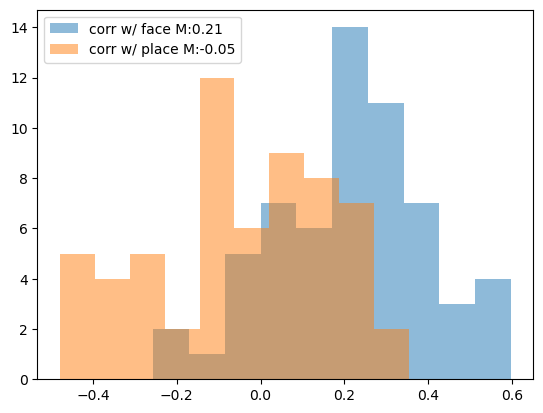

In [912]:
rfx_facecor = [np.corrcoef(ffa_arr,face_reg)[0,1] for ffa_arr in ffa_arrs]
rfx_placecor = [np.corrcoef(ffa_arr,place_reg)[0,1] for ffa_arr in ffa_arrs]

rfx_facecor = np.array(rfx_facecor)
rfx_placecor = np.array(rfx_placecor)

plt.hist(rfx_facecor,alpha=.5)
plt.hist(rfx_placecor,alpha=.5)

plt.legend(['corr w/ face M:{:.2f}'.format(rfx_facecor.mean()),'corr w/ place M:{:.2f}'.format(rfx_placecor.mean())])

In [913]:
#s = 21
s = 21
rfx_facecor[s],rfx_placecor[s]

(0.17908971659816042, 0.2059304007881014)

In [903]:
vals = {};
vals['corr2face'] = []
vals['corr2place'] = []
vals['betas']=[]

for s in tqdm(range(len(subs))):
    sub = subs[s]
    for r in [1,2]:
        mot = pd.read_csv(mot_fn.format(sub=sub,r=r),delimiter='\t')
        
        im = ants.image_read(epi_fn.format(sub=sub,r=r))
        im_arr = im.numpy()
        im_arr[:,:,:,0:8] = im_arr[:,:,:,8::].mean(axis=-1)[:,:,:,np.newaxis]
        
        t_r = 0.8  # repetition time is 1 second
        n_scans = im_arr.shape[-1]  # the acquisition comprises 128 scans
        frame_times = (np.arange(n_scans) * t_r)
        
        X1 = make_first_level_design_matrix(frame_times,mot,drift_model="polynomial",drift_order=3,hrf_model="SPM") #
        face_regressor = X1[['0_back_negface','0_back_neutface','0_back_posface','2_back_negface','2_back_neutface','2_back_posface']].values.sum(axis=1)
        place_regressor = X1[['0_back_place','2_back_place']].values.sum(axis=1)
        
        #vec = im_arr[ffa.numpy()==1].mean(axis=0)[X1_sorted['idx'].values]
        ffa_vals = im_arr[ffa.numpy()==1]
        #ffa_vals = ((ffa_vals-ffa_vals.mean())/ffa_vals.std())
        vals['corr2face'].append( np.corrcoef(ffa_vals.mean(axis=0),face_regressor)[0,1] )
        vals['corr2place'].append(np.corrcoef(ffa_vals.mean(axis=0),place_regressor)[0,1])
        vals['betas'].append(np.linalg.lstsq(X1.values, ffa_vals.transpose(), rcond=None)[0].mean(axis=1))

100%|███████████████████████████████████████████| 30/30 [04:06<00:00,  8.21s/it]


In [914]:
print(np.array(vals['corr2face']).mean())
print(np.array(vals['corr2place']).mean())

0.27693965755214583
-0.01688330756433902


(array([ 3.,  2.,  4.,  3., 10.,  7.,  7.,  7., 11.,  6.]),
 array([-0.47382157, -0.39632499, -0.3188284 , -0.24133181, -0.16383523,
        -0.08633864, -0.00884205,  0.06865453,  0.14615112,  0.22364771,
         0.30114429]),
 <BarContainer object of 10 artists>)

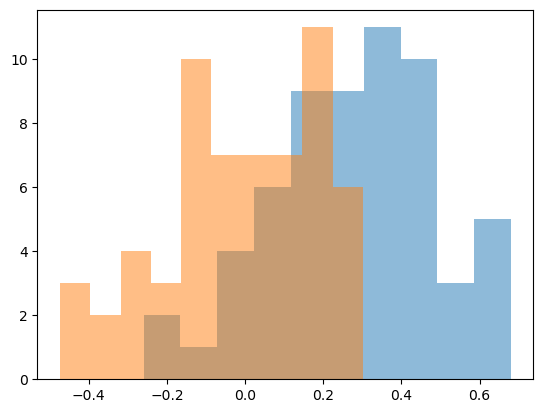

In [915]:
plt.hist(vals['corr2face'],alpha=.5)
plt.hist(vals['corr2place'],alpha=.5)

In [916]:
betas = pd.DataFrame(np.array(vals['betas']),columns=X1.columns)

In [917]:
face_beta_avg = betas[['0_back_negface','0_back_neutface','0_back_place','0_back_posface','2_back_negface','2_back_neutface','2_back_place','2_back_posface']].values.mean(axis=1)
place_beta_avg = betas[['2_back_place','0_back_place']].values.mean(axis=1)
noise_beta_avg = betas[['cue', 'dummy', 'drift_1', 'drift_2', 'drift_3', 'constant']].values.mean(axis=1)

In [918]:
diff = face_beta_avg-place_beta_avg

In [919]:
(face_beta_avg.mean(),place_beta_avg.mean(),diff.mean(),noise_beta_avg.mean())

(37.96537610782615, 28.555820561675368, 9.409555546150775, 598.1083484736106)

([<matplotlib.axis.XTick at 0x155463ab0eb0>,
 [Text(0, 0, 'face'), Text(1, 0, 'place'), Text(2, 0, 'diff')])

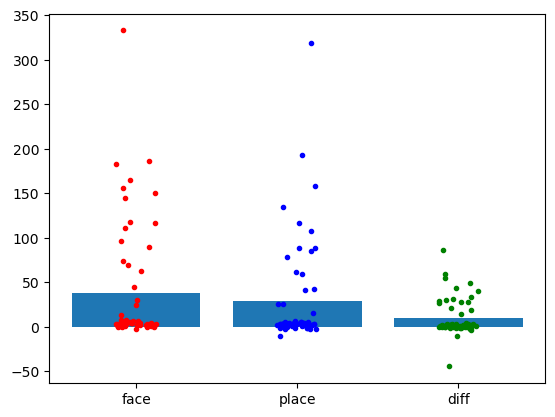

In [920]:
plt.bar([0,1,2],(face_beta_avg.mean(),place_beta_avg.mean(),diff.mean()) )

ys = face_beta_avg
n = len(ys)
xs = np.ones(n)*0+(np.random.rand(n)-.5)*.25
plt.plot(xs,ys,'r.')

ys = place_beta_avg
n = len(ys)
xs = np.ones(n)*1+(np.random.rand(n)-.5)*.25
plt.plot(xs,ys,'b.')
plt.xticks([0,1],labels=['face','place'])

ys = diff
n = len(ys)
xs = np.ones(n)*2+(np.random.rand(n)-.5)*.25
plt.plot(xs,ys,'g.')
plt.xticks([0,1,2],labels=['face','place','diff'])